In [1]:
!pip install scikit-learn==1.3.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb


In [2]:
# Load CSV file into a DataFrame
file_path = "/content/IBM.csv"
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())


                       Price           Adj Close               Close  \
0                     Ticker                 IBM                 IBM   
1                       Date                 NaN                 NaN   
2  2014-08-01 00:00:00+00:00  115.99971771240234   180.8317413330078   
3  2014-08-04 00:00:00+00:00  116.30024719238281  181.30018615722656   
4  2014-08-05 00:00:00+00:00   114.7425537109375  178.87188720703125   

                 High                 Low                Open   Volume  
0                 IBM                 IBM                 IBM      IBM  
1                 NaN                 NaN                 NaN      NaN  
2  183.07839965820312   180.5544891357422  182.12237548828125  5419431  
3   181.5965576171875  180.30592346191406     181.02294921875  2223691  
4  180.87954711914062   178.2409210205078  180.44932556152344  3460063  


In [3]:
print(data.info())
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      2351 non-null   object
 1   Adj Close  2350 non-null   object
 2   Close      2350 non-null   object
 3   High       2350 non-null   object
 4   Low        2350 non-null   object
 5   Open       2350 non-null   object
 6   Volume     2350 non-null   object
dtypes: object(7)
memory usage: 128.7+ KB
None
Price        0
Adj Close    1
Close        1
High         1
Low          1
Open         1
Volume       1
dtype: int64


In [4]:
# Drop metadata rows
data = data.iloc[2:].reset_index(drop=True)

# Rename the 'Date' column for clarity
data.rename(columns={'Price': 'Date'}, inplace=True)

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Select relevant columns (e.g., Adj Close)
data = data[['Date', 'Adj Close','Close', 'High', 'Low', 'Open', 'Volume']]

# Convert numeric columns to float
for col in ['Adj Close','Close', 'High', 'Low', 'Open', 'Volume']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle missing values (forward fill for prices, zero fill for volume)
data.fillna(method='ffill', inplace=True)
data.set_index('Date', inplace=True)

<ipython-input-4-401ced53bf75>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [5]:
data.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-08-01 00:00:00+00:00,115.999718,180.831741,183.078400,180.554489,182.122375,5419431
2014-08-04 00:00:00+00:00,116.300247,181.300186,181.596558,180.305923,181.022949,2223691
2014-08-05 00:00:00+00:00,114.742554,178.871887,180.879547,178.240921,180.449326,3460063
2014-08-06 00:00:00+00:00,114.724037,177.791580,178.661575,176.328873,177.208420,4023962
2014-08-07 00:00:00+00:00,113.693794,176.195023,178.470367,175.506699,178.432129,2833196


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2349 entries, 2014-08-01 00:00:00+00:00 to 2023-11-29 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2349 non-null   float64
 1   Close      2349 non-null   float64
 2   High       2349 non-null   float64
 3   Low        2349 non-null   float64
 4   Open       2349 non-null   float64
 5   Volume     2349 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 128.5 KB


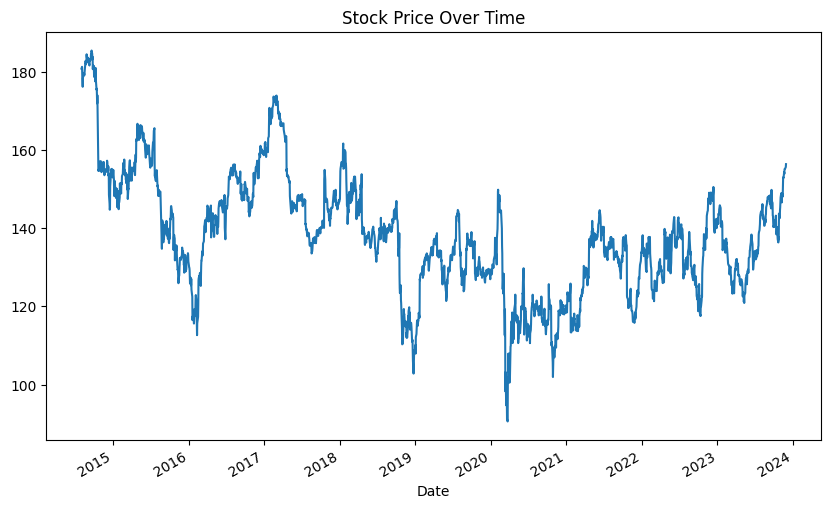

In [7]:
import matplotlib.pyplot as plt
data['Close'].plot(figsize=(10, 6), title='Stock Price Over Time')
plt.show()


In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")


ADF Statistic: -3.8074522577975296
p-value: 0.002831982354675904
The time series is stationary.


In [9]:
data['lag_1'] = data['Close'].shift(1)
data['lag_2'] = data['Close'].shift(2)


In [10]:
data['rolling_mean'] = data['Close'].rolling(window=7).mean()
data['rolling_std'] = data['Close'].rolling(window=7).std()


In [11]:
data['day_of_week'] = data.index.dayofweek


In [12]:
data.dropna(inplace=True)


In [13]:
train_size = int(len(data) * 0.8)  # 80% for training
train_data = data[:train_size]
test_data = data[train_size:]

# Separate features (X) and target (y)
X_train = train_data.drop(columns=['Close'])
y_train = train_data['Close']
X_test = test_data.drop(columns=['Close'])
y_test = test_data['Close']


In [14]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.9171479637163685


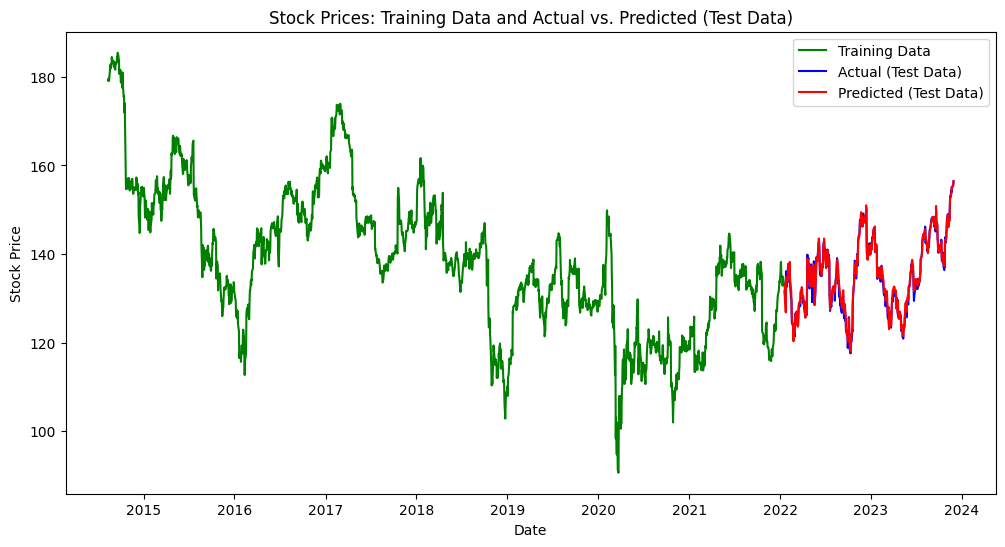

In [15]:
plt.figure(figsize=(12, 6))
# Plot the training data
plt.plot(train_data.index, y_train, label='Training Data', color='green')
# Plot the actual test data
plt.plot(test_data.index, y_test, label='Actual (Test Data)', color='blue')
# Plot the predicted test data
plt.plot(test_data.index, y_pred, label='Predicted (Test Data)', color='red')
# Add titles and legend
plt.title('Stock Prices: Training Data and Actual vs. Predicted (Test Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")


Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}


In [17]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

random_search = RandomizedSearchCV(estimator=XGBRegressor(objective='reg:squarederror'),
                                   param_distributions=param_distributions,
                                   cv=3, n_iter=10, random_state=42)
random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")


Best Parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}


In [18]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize the model
model1 = XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.2, max_depth=3)

# Fit the model
model1.fit(X_train, y_train)

# Predict on the test set
y_pred = model1.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 0.7930083865977962
Root Mean Squared Error (RMSE): 0.8905101833206603
Mean Absolute Error (MAE): 0.6735694088152986


In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize the model
model2 = XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=3)

# Fit the model
model2.fit(X_train, y_train)

# Predict on the test set
y_pred = model2.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 0.7854375224258912
Root Mean Squared Error (RMSE): 0.8862491311284266
Mean Absolute Error (MAE): 0.6788523171756313


In [20]:
import joblib
joblib.dump(model2, 'xgboost_stock_model.pkl')


['xgboost_stock_model.pkl']

In [21]:
# Load the saved model
loaded_model = joblib.load('xgboost_stock_model.pkl')

# Use the loaded model for predictions
y_pred_loaded = loaded_model.predict(X_test)


In [22]:
print(loaded_model.get_params())


{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [23]:
# Get the booster object
booster = loaded_model.get_booster()

# Print feature importance
print(booster.get_score(importance_type='weight'))


{'Adj Close': 170.0, 'High': 263.0, 'Low': 260.0, 'Open': 108.0, 'Volume': 176.0, 'lag_1': 122.0, 'lag_2': 81.0, 'rolling_mean': 75.0, 'rolling_std': 104.0, 'day_of_week': 24.0}


0:[High<142.342255] yes=1,no=2,missing=2
	1:[Low<123.326958] yes=3,no=4,missing=4
		3:[Low<112.284897] yes=7,no=8,missing=8
			7:leaf=-2.95072031
			8:leaf=-2.00225973
		4:[High<133.986618] yes=9,no=10,missing=10
			9:leaf=-0.920301557
			10:leaf=-0.155317843
	2:[Low<157.810699] yes=5,no=6,missing=6
		5:[High<151.587006] yes=11,no=12,missing=12
			11:leaf=0.711897492
			12:leaf=1.53345942
		6:[Low<169.703629] yes=13,no=14,missing=14
			13:leaf=2.46538568
			14:leaf=3.95225



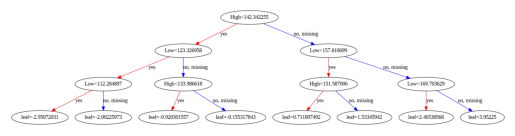

In [24]:
# Dump model as text
print(booster.get_dump()[0])  # Displays the first tree

# Plot a tree (requires matplotlib)
from xgboost import plot_tree
import matplotlib.pyplot as plt

plot_tree(loaded_model, num_trees=0)
plt.show()


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', XGBRegressor(objective='reg:squarederror'))
])

# Train and save the pipeline
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, 'xgboost_stock_pipeline.pkl')

# Load and use the pipeline
loaded_pipeline = joblib.load('xgboost_stock_pipeline.pkl')
y_pred_pipeline = loaded_pipeline.predict(X_test)


In [28]:
import time

# Measure inference time
start_time = time.time()
y_pred = loaded_model.predict(X_test)
print(f"Inference Time: {time.time() - start_time} seconds")


Inference Time: 0.037395477294921875 seconds


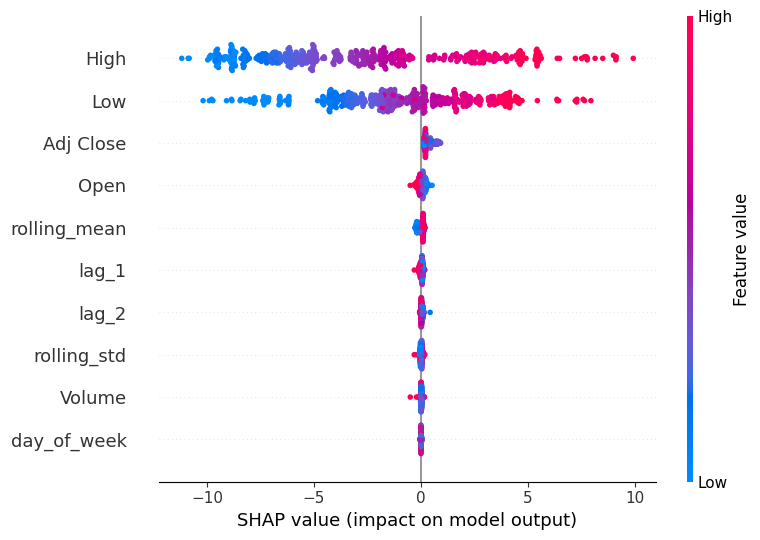

In [29]:
import shap

# Explain predictions
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot SHAP values
shap.summary_plot(shap_values, X_test)
